## Setup

In [1]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import cv2
import pandas as pd
import numpy as np
import datetime
from PIL import Image
    
from tensorflow import keras
from keras import layers

In [2]:
import tensorflow as tf

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-12-01 08:01:28.474719: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 08:01:29.326538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 14640 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3108808844178476809
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15352135680
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1701889323223253614
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"
 xla_global_id: 416903419]

## 하이퍼 파라미터

In [3]:
# 데이터
# 사용할 데이터셋 이름 : tf.dataset
# dataset_name = "oxford_flowers102"
dataset_name = "cifar10"
# 반복할 횟수(1이상으로 잡아야 돌아갑니다.)
dataset_repetitions = 3
# Epoch
num_epochs = 50
# resize시 정할 이미지
# image_size = 256
image_size = 32


# KID = Kernel Inception Distance, see related section
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 64
# batch_size = 16
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

# class
num_class = 10
class_embedding_dims = 32

In [4]:
tfds.load(dataset_name)

2022-12-01 08:01:29.355741: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14640 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0


{'train': <PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

## 데이터 파이프라인

### 변경 전

In [5]:
# 이미지의 너비와 높이 중 짧은 길이에 맞춰서 center crop하는 함수
def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    
    # Center crop한 이미지를 Hyper parameter에서 정해준 image_size에 맞게 resize 해줍니다.
    # resize시 이미지 훼손을 최대한 방지하기 위해 antialias를 True로 해줍니다.
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    # 이미지 Array의 값을 float 0~1로 만들어주고 혹시 모를 특이값을 방지하기 위해 clip을 해줍니다.
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)


# 데이터셋을 준비하는 함수
def prepare_dataset(split):
    # KID 측정을 위해서는 shuffle이 되어야 합니다. 데이터 순서가 영향을 주기 때문입니다.
    return (
        # tfds.load를 통해 Hyper parameter에서 정해준 이름의 Dataset을 불러옵니다.
        # 추가로 split 문자열을 통해 train, (validation), test에서 나눠서 가져옵니다.
        # shuffle_files를 통해 파일을 섞어줍니다.
        tfds.load(dataset_name, split=split, shuffle_files=True, )
        # map 함수는 해당 함수(ppreprocess_image)를 내부의 값에 모두 적용하는 함수 입니다.
        # num_parallel_calls : 병렬적으로 수행할 요소들의 숫자를 정합니다.
        # tf.data.AUTOTUNE을 적용하면 현재 CPU에 맞게 적용됩니다.
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        # 해당 데이터셋의 내부 원소들을 캐시합니다.
        # (캐시 : CPU와 주 메모리 사이에 삽입되는 작고 빠른 메모리 구성요소)
        # 캐시한다 : 여기에 데이터를 올려서 속도 개선
        .cache()
        # 내부 모든 값을 반복합니다.(여러번 concate 한다고 생각하면 됩니다.)
        .repeat(dataset_repetitions)
        # shuffle
        # buffer : 데이터를 전송하기 전에 일시적으로 데이터를 보관하는 메모리의 영역(이동하고자하는 모든 데이터를 담게 된다.)
        .shuffle(10 * batch_size)
        # batch_size에 맞춰 batch를 나눕니다. drop_remainder = True가 된다면 batch 보다 적게 남으면 버립니다.
        .batch(batch_size, drop_remainder=True)
        # 대부분의 Dataset이 prefetch를 통해 끝이 난다.
        # prefetch는 나중의 요소들이 현재 요소들이 계산되느 동안 준비되게 한다.
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

# 데이터셋 불러오기
# train 데이터셋은 train, validation, test의 0~80 부분을 가져옵니다.
# train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
# test 데이터셋은 train, validation, test의 80~100 부분을 가져옵니다.
# val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

# print(train_dataset)
# print(val_dataset)

### 변경

In [6]:
# 이미지의 너비와 높이 중 짧은 길이에 맞춰서 center crop하는 함수
def preprocess_image_2(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )
    c_vect = tf.one_hot(data["label"], num_class)
    # Center crop한 이미지를 Hyper parameter에서 정해준 image_size에 맞게 resize 해줍니다.
    # resize시 이미지 훼손을 최대한 방지하기 위해 antialias를 True로 해줍ㄴ디ㅏ.
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    # 이미지 Array의 값을 float 0~1로 만들어주고 혹시 모를 특이값을 방지하기 위해 clip을 해줍니다.
    return {'image': tf.clip_by_value(image / 255.0, 0.0, 1.0), 'label' : c_vect}


# 데이터셋을 준비하는 함수
def prepare_dataset_2(split):
    # KID 측정을 위해서는 shuffle이 되어야 합니다. 데이터 순서가 영향을 주기 때문입니다.
    # tfds.load를 통해 Hyper parameter에서 정해준 이름의 Dataset을 불러옵니다.
    # 추가로 split 문자열을 통해 train, (validation), test에서 나눠서 가져옵니다.
    # shuffle_files를 통해 파일을 섞어줍니다.
    # map 함수는 해당 함수(ppreprocess_image)를 내부의 값에 모두 적용하는 함수 입니다.
    # num_parallel_calls : 병렬적으로 수행할 요소들의 숫자를 정합니다.
    # tf.data.AUTOTUNE을 적용하면 현재 CPU에 맞게 적용됩니다.
    # 해당 데이터셋의 내부 원소들을 캐시합니다.
    # (캐시 : CPU와 주 메모리 사이에 삽입되는 작고 빠른 메모리 구성요소)
    # 캐시한다 : 여기에 데이터를 올려서 속도 개선
    # 내부 모든 값을 반복합니다.(여러번 concate 한다고 생각하면 됩니다.)
    # shuffle
    # buffer : 데이터를 전송하기 전에 일시적으로 데이터를 보관하는 메모리의 영역(이동하고자하는 모든 데이터를 담게 된다.)
    # batch_size에 맞춰 batch를 나눕니다. drop_remainder = True가 된다면 batch 보다 적게 남으면 버립니다.
    # 대부분의 Dataset이 prefetch를 통해 끝이 난다.
    # prefetch는 나중의 요소들이 현재 요소들이 계산되느 동안 준비되게 한다.
    
    dataset = tfds.load(dataset_name, split=split, shuffle_files=True)
    dataset = dataset.map(preprocess_image_2, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache().repeat(dataset_repetitions)
    dataset = dataset.shuffle(10 * batch_size)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset


# 데이터셋 불러오기
# train 데이터셋은 train의 0~80 부분을 가져옵니다.
train_dataset = prepare_dataset_2("train[:80%]")

# test 데이터셋은 train의 80~100 부분을 가져옵니다.
val_dataset = prepare_dataset_2("train[80%:]")

print(train_dataset)
print(val_dataset)

<PrefetchDataset element_spec={'image': TensorSpec(shape=(64, 32, 32, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(64, 10), dtype=tf.float32, name=None)}>
<PrefetchDataset element_spec={'image': TensorSpec(shape=(64, 32, 32, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(64, 10), dtype=tf.float32, name=None)}>


### 데이터셋 확인

(64, 10)
(64, 32, 32, 3)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)


2022-12-01 08:01:30.262711: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-12-01 08:01:30.262951: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


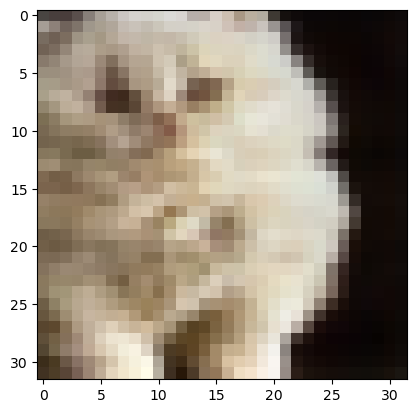

In [7]:
## take(n) : batch n개를 가져옵니다.
train_sample = train_dataset.take(1)

for sample in train_sample:
    print(sample['label'].shape)
    print(sample['image'].shape)
    print(sample['label'][0])
    plt.imshow(sample['image'][0])

## KID

* KID : Kernel Inception Distance
* MMD(Maximum Mean Discrepancy)를 feature space에서 진행하는 것을 의미
* 실제 이미지와 가짜 이미지, 가짜 이미지와 실제 이미지 세트간의 similarity를 보는 방법
* 실제 이미지 셋 p, 가짜 이미지셋 q라고 두고
* p에서 2장을 뽑고 두 이미지간의 차이를 구하는 것을 반복해서 이미지들간의 차이가 어떻게 되는지 기댓값을 구합니다.
* q에서도 똑같은 행동을 취합니다.
* 마지막으로 p에서 하나, q에서 하나를 뽑아서 평균적인 차이를 구합니다.

In [8]:
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID 배치마다 계산되며 배치간의 값들로 평균을 냅니다.
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()


## 네트워크 구조

* U-Net 구조 : Input과 Output이 동일한 형태로
* Downsampling 한 뒤 Upsampling 하는 구조, layer들 간의 skip connectoins은 같은 resolutoin을 가진다.
* 네트워크는 noisy image와 noisy variances 2개의 값을 입력 받습니다.
* Noise variances는 노이즈 제거 과정이 다른 레벨의 노이즈에서 다른 명령(함수)가 필요하기 때문입니다.
* Noise variacnes는 sinusoidal embedding(positional embedding과 비슷한)을 통해 변환됩니다.
* 이 과정은 네트워크가 noise level에 매우 민감하게 만들어주며 이는 좋은 성능과 연결됩니다.
* Lambda layer를 통해 sinusoidal embedding을 구현하였습니다.

### Sinusoidal Embedding

In [9]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

### Residual Block

In [10]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

### Up Down Block

In [11]:
def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

### Get Network

### Before

In [12]:
# def get_network_before(image_size, widths, block_depth):
#     noisy_images = keras.Input(shape=(image_size, image_size, 3))
#     noise_variances = keras.Input(shape=(1, 1, 1))

#     e = layers.Lambda(sinusoidal_embedding)(noise_variances)
#     e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

#     x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
#     x = layers.Concatenate()([x, e])

#     skips = []
#     for width in widths[:-1]:
#         x = DownBlock(width, block_depth)([x, skips])

#     for _ in range(block_depth):
#         x = ResidualBlock(widths[-1])(x)

#     for width in reversed(widths[:-1]):
#         x = UpBlock(width, block_depth)([x, skips])

#     x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

#     return keras.Model([noisy_images, noise_variances], x, name="residual_unet")


### After

In [13]:
def get_network(image_size, widths, num_class, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))
    class_vector = keras.Input(shape = (num_class,))
    
    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
#     print('e :', e)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)
#     print('e :',e)
    
    i = layers.Dense(class_embedding_dims)(class_vector)
#     print('i :',i)
#     i = layers.Reshape((1,1,class_embedding_dims))(i)
    i = i[:,None,None,:]
#     print('i :',i)
    i = layers.UpSampling2D(size=image_size, interpolation="nearest")(i)
#     print('i :',i)
    
    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, i, e])
#     print('x', x)

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)
#     x = layers.Conv2D(1, kernel_size=1, kernel_initializer="zeros")(x)
    

    return keras.Model([noisy_images, noise_variances, class_vector], x, name="residual_unet")

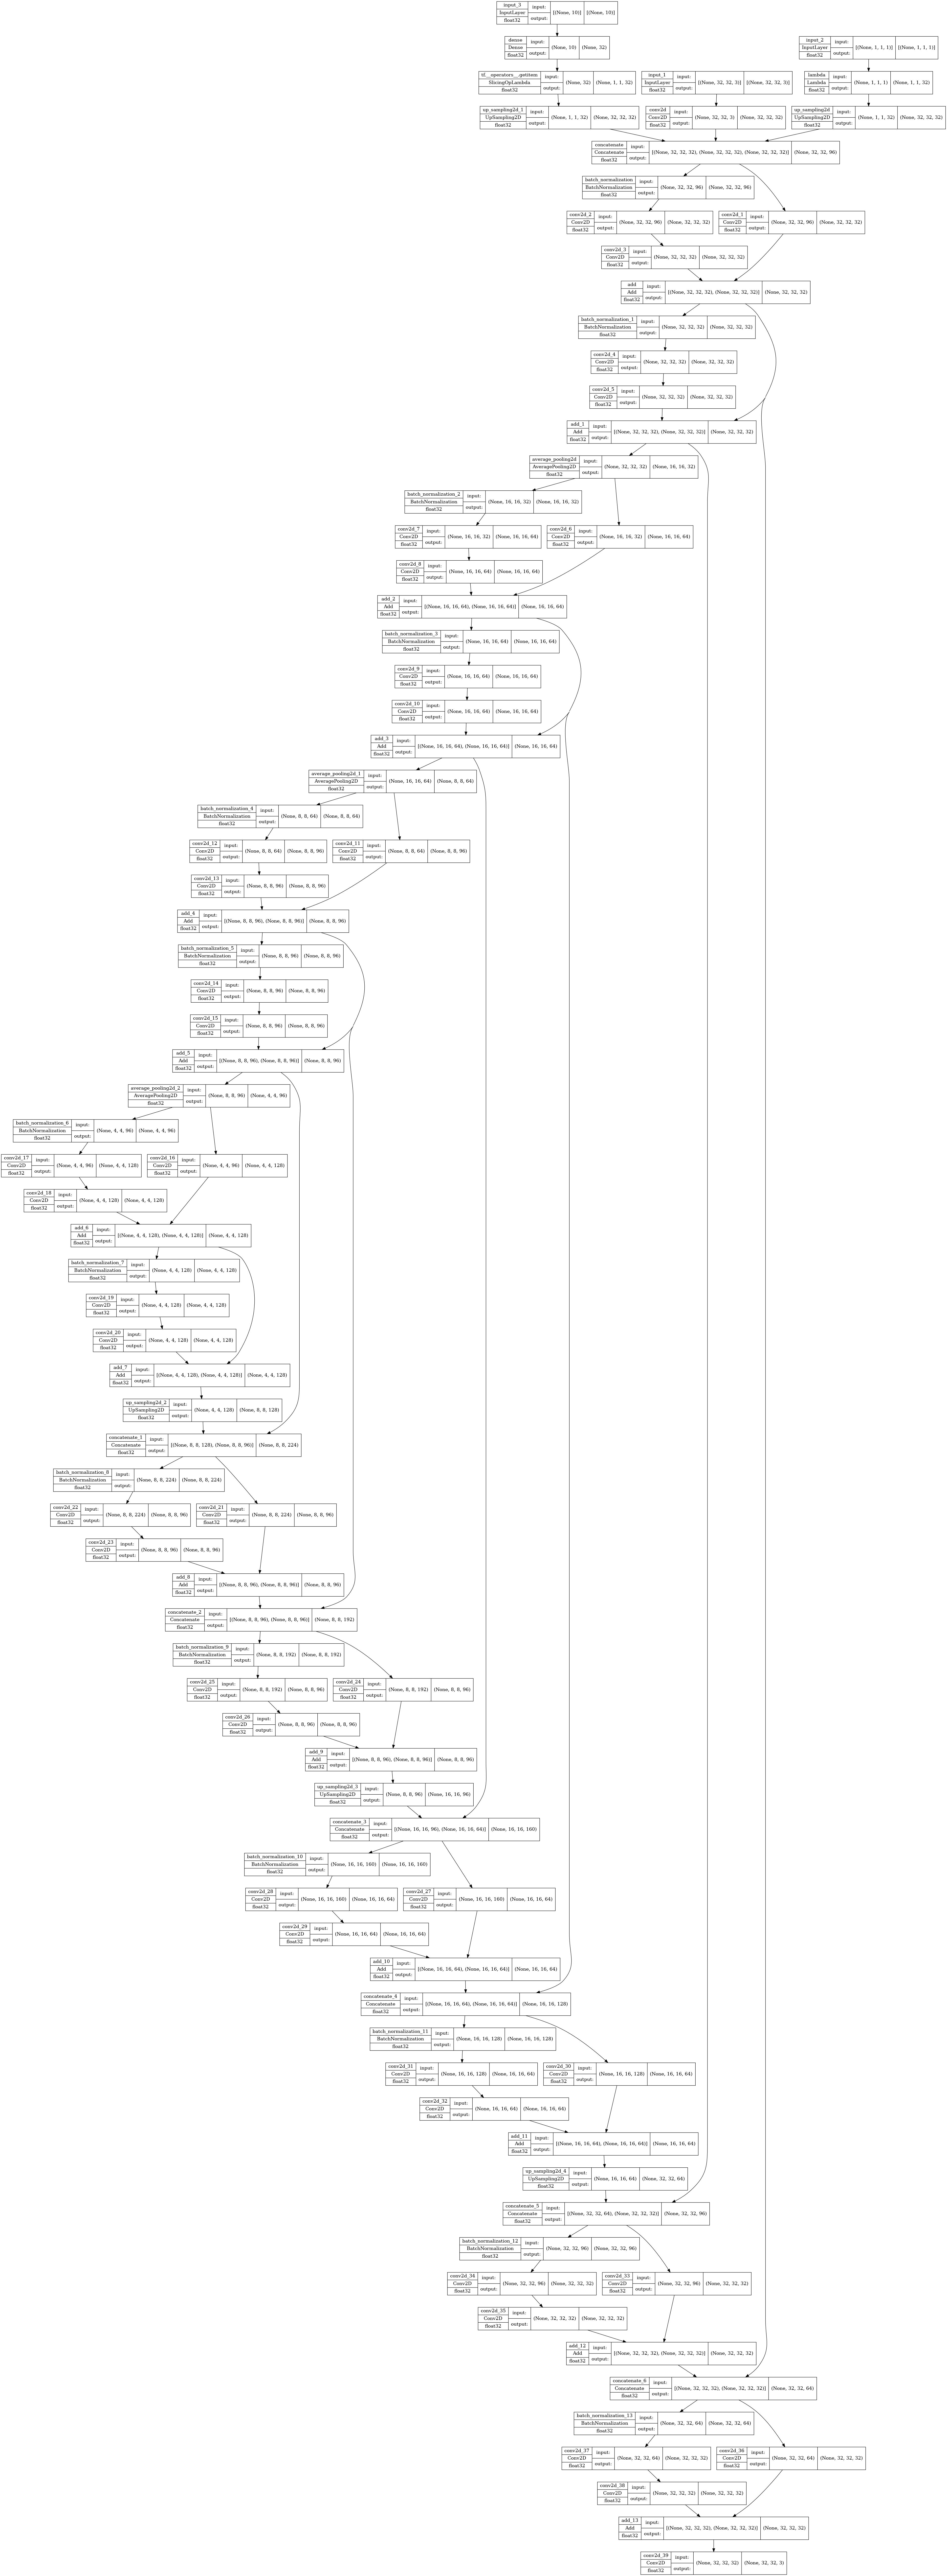

In [14]:
from tensorflow.keras.utils import plot_model

sample_network = get_network(image_size, widths, num_class, block_depth)

plot_model(sample_network, to_file = 'model.png', show_shapes = True, show_dtype = True, show_layer_names = True)


## Diffusion model

### Diffusion Schedule

* Diffusion process의 각 위치에서의 실제 diffusion time에 대응하는 noise level과 signal level를 말해주는 함수가 필요하다.
* 이것이 diffusion schedule 이다.
* Diffusion schedule은 2가지 값을 출력한다.
* noise_rate와 signal_rate(DDPM 논문에서 sqrt(1-alpha)와 sqrt(alpha)에 해당하는)
* 노이즈 이미지는 훈련 이미지에 정해진 비율에 따라 랜덤 노이즈를 부가하고 둘을 합치면서 생성한다.
* 랜덤 노이즈와 이미지가 모두 평균을 0으로 잡고 unit 분산을 가지기 때문에 노이즈 비율과 신호 비율은 노이즈 이미지에서 그들의 표준편차로 볼 수 있다.
* 그들 비율의 제곱은 결국 분산이 된다.
* 비율들은 제곱 합이 1이 되도록 설정되며, 이는 노이즈 이미지가 언제나 unit 분산을 가지는 것을 뜻합니다(변화되지않은 값들 처럼)
* 우린 cosine schedule의 simplifed, continuous 버전을 사용합니다.
* 이 스케쥴은 대칭적이며 Diffusion 시작과 끝을 향해선 느려지며, trigonometric properties of the unit circle을 통한 기하하적 해석을 가집니다.

### Training Process

* train 과정은 train_step과 denoise 이며
* 무작위 diffusion 시간을 균등하게 샘플하며
* 훈련 이미지와 무작위 가우시안 노이즈를 diffusion 시간에 따른 비율에 따라 섞습니다.
* 그리고 노이즈 이미지를 두 가지 요소로 나누기 위해 모델을 훈련합니다.
* 뉴런 네트워크는 변하지 않은 노이즈 요소를 예측하기 위해 학습되며 예측한 이미지 요소는 신호와 노이즈 비율에 따라 계산될 수 있습니다.
* 픽셀 단위의 MSE가 이론적으로 사용되나, 해당 dataset에서는 MAE가 더 좋게 나오니 이것을 사용하겠습니다.

### Sampling

* 샘플링에서는 (reverse diffusion()에서), 각 단계에서 노이즈 이미지의 이전 예측값을 우리의 네트워크를 사용해서 노이즈와 이미지로 나눕니다.
* 해당 단계에서의 신호와 노이즈 비율을 사용하여 다시 재결합합니다.
* Stochastic sampling 네트워크를 재훈련하지 않고도 사용할 수 있다(두 모델 다 같은 방식으로 훈련하기 때문)

In [15]:
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, num_class, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, num_class, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, class_vector, training):
        # print("denoise start")
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        # pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_noises = network([noisy_images, noise_rates**2, class_vector], training=training)
        # print("denoise get noises")
    
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        # print("denoise get images") 
        
        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps, class_vector):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, class_vector, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps, class_vector):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps, class_vector)
        generated_images = self.denormalize(generated_images)
        return generated_images

    # def train_step(self, images):
    def train_step(self, data):
        # normalize images to have standard deviation of 1, like the noises
        # print("train_step start")
        images = data['image']
        label = data['label']
        # print(label)
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # print("train_step here 1")
        # print("noise_rates :", noise_rates)
        # print("signal_rates :", signal_rates)
        # print("noisy_images :", noisy_images)
        
        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, label, training=True
            )
            # print('start get loss')
            noise_loss = self.loss(noises, pred_noises)  # used for training
            # print('get noise loss')
            image_loss = self.loss(images, pred_images)  # only used as metric
            # print('get image loss')
            
            
        # print("train_step here 2")
        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)
    
        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    # def test_step(self, images):
    def test_step(self, data):
        images = data['image']
        label = data['label']
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, label, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps, class_vector = label
        )
        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    # plot random generated images for visual evaluation of generation quality
    def plot_images(self, epoch=None, logs=None, num_rows=2, num_cols=5):
#     def plot_images(self, epoch=None, logs=None, num_rows=1, num_cols=5):
        
        indices = [0,1,2,3,4,5,6,7,8,9]
#         indices = [0,1,2,3,4]
        sample_vector = tf.one_hot(indices, num_class)
            
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
            class_vector =  sample_vector 
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()
    

## 학습

In [16]:
!pip install tensorflow_addons

/bin/bash: /home/paul025220/anaconda3/envs/itoi/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [17]:
import tensorflow_addons as tfa

# create and compile the model
model = DiffusionModel(image_size, widths, num_class, block_depth)
# below tensorflow 2.9:
# pip install tensorflow_addons
# import tensorflow_addons as tfa
# optimizer=tfa.optimizers.AdamW
model.compile(
    optimizer=tfa.optimizers.AdamW(
#     optimizer=keras.optimizers.experimental.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.MeanSquaredError(),
)
# pixelwise mean absolute error is used as loss

In [18]:
# save the best model based on the validation KID metric
checkpoint_path = "checkpoint/diffusion_model"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

# calculate mean and variance of training dataset for normalization
# model.normalizer.adapt(train_dataset)

Epoch 1/50


2022-12-01 08:01:43.893245: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-12-01 08:01:44.445942: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-01 08:01:44.446830: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-01 08:01:44.446874: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-01 08:01:44.447608: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-01 08:01:44.448643: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1874/1875 [============================>.] - ETA: 0s - n_loss: 0.0283 - i_loss: 0.4394

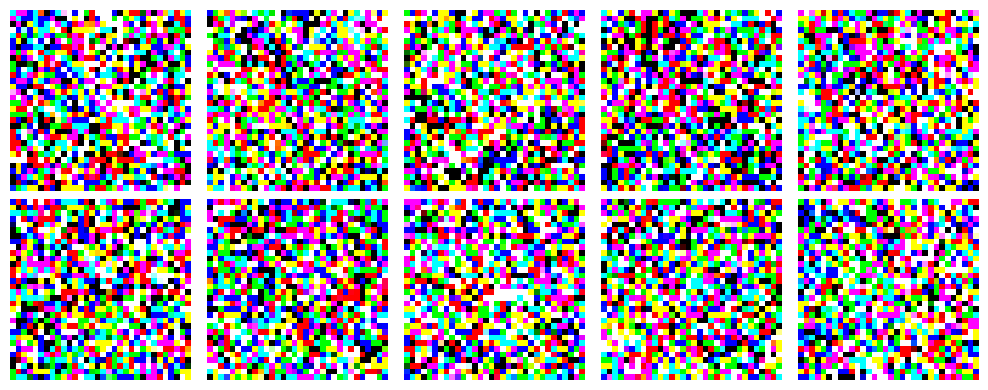

1875/1875 [==============================] - 86s 43ms/step - n_loss: 0.0283 - i_loss: 0.4392 - val_n_loss: 0.4121 - val_i_loss: 12.6847 - val_kid: 0.8247
Epoch 2/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0165 - i_loss: 0.0699

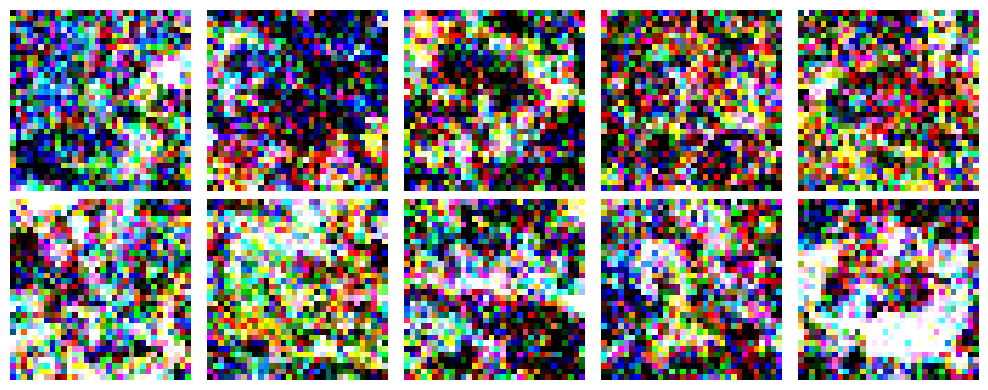

1875/1875 [==============================] - 72s 38ms/step - n_loss: 0.0165 - i_loss: 0.0699 - val_n_loss: 0.0422 - val_i_loss: 0.8182 - val_kid: 0.6651
Epoch 3/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0159 - i_loss: 0.0604

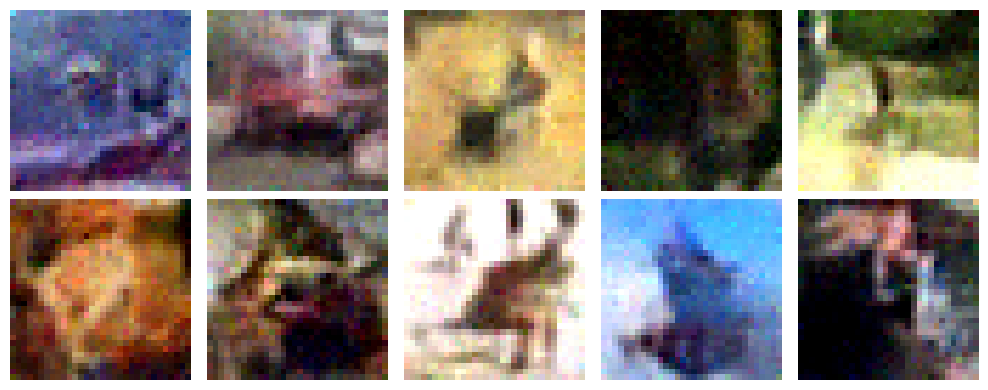

1875/1875 [==============================] - 72s 38ms/step - n_loss: 0.0159 - i_loss: 0.0604 - val_n_loss: 0.0161 - val_i_loss: 0.0601 - val_kid: 0.3691
Epoch 4/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0156 - i_loss: 0.0549

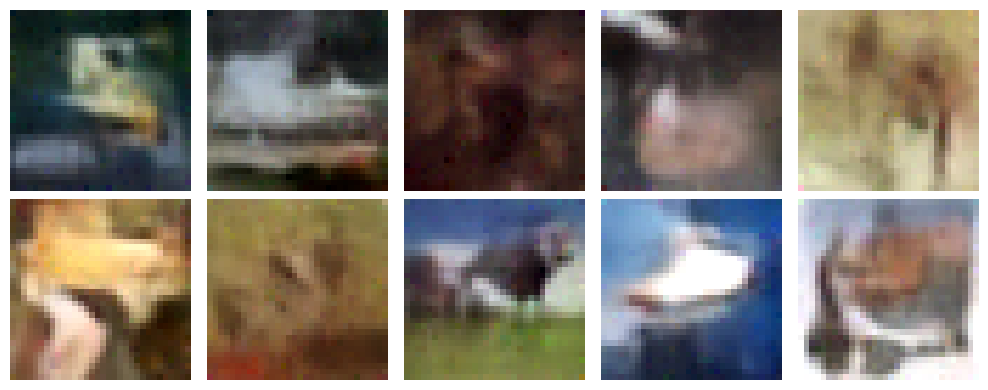

1875/1875 [==============================] - 72s 39ms/step - n_loss: 0.0156 - i_loss: 0.0548 - val_n_loss: 0.0146 - val_i_loss: 0.0312 - val_kid: 0.2837
Epoch 5/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0154 - i_loss: 0.0528

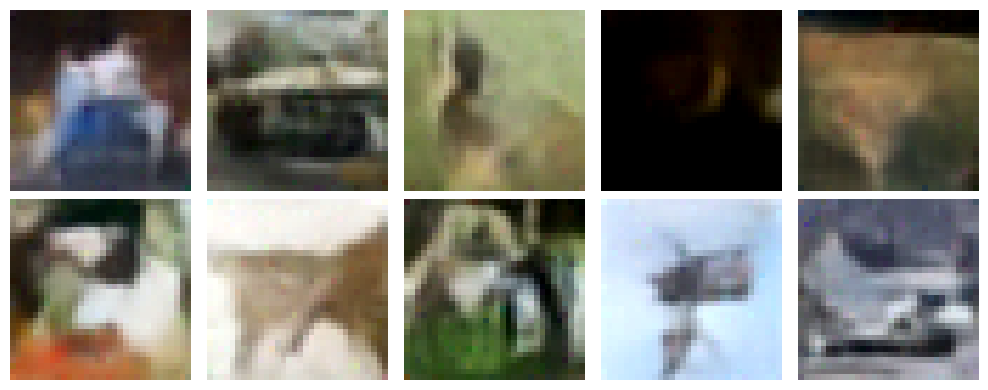

1875/1875 [==============================] - 72s 39ms/step - n_loss: 0.0154 - i_loss: 0.0528 - val_n_loss: 0.0144 - val_i_loss: 0.0295 - val_kid: 0.2673
Epoch 6/50
1875/1875 [==============================] - ETA: 0s - n_loss: 0.0153 - i_loss: 0.0492

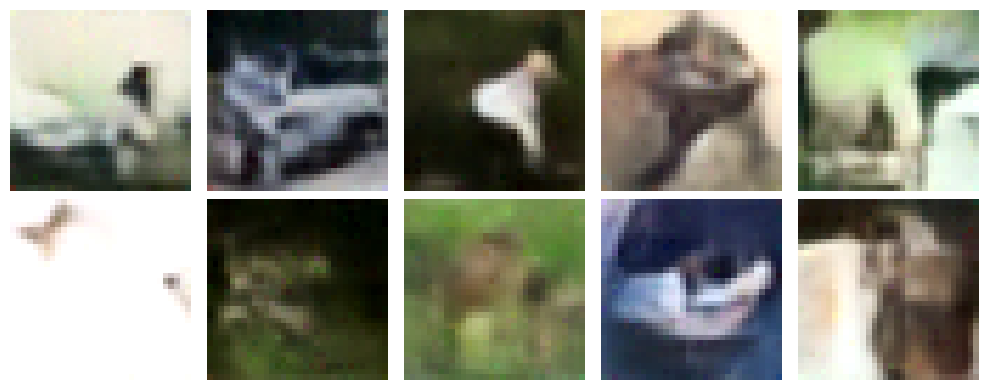

1875/1875 [==============================] - 72s 38ms/step - n_loss: 0.0153 - i_loss: 0.0492 - val_n_loss: 0.0143 - val_i_loss: 0.0285 - val_kid: 0.2626
Epoch 7/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0151 - i_loss: 0.0466

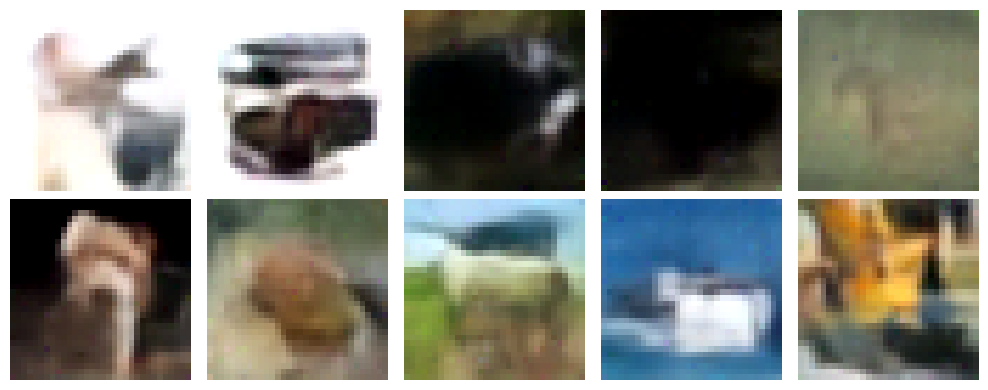

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0151 - i_loss: 0.0466 - val_n_loss: 0.0142 - val_i_loss: 0.0284 - val_kid: 0.2641
Epoch 8/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0151 - i_loss: 0.0446

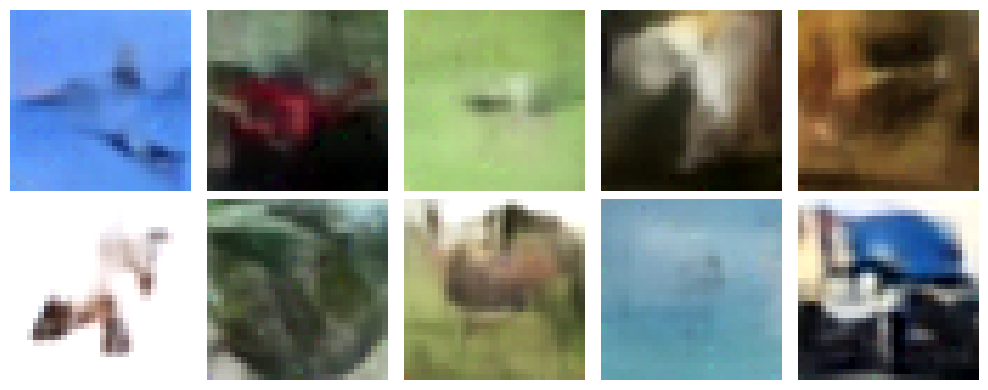

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0151 - i_loss: 0.0446 - val_n_loss: 0.0142 - val_i_loss: 0.0271 - val_kid: 0.2645
Epoch 9/50
1875/1875 [==============================] - ETA: 0s - n_loss: 0.0149 - i_loss: 0.0442

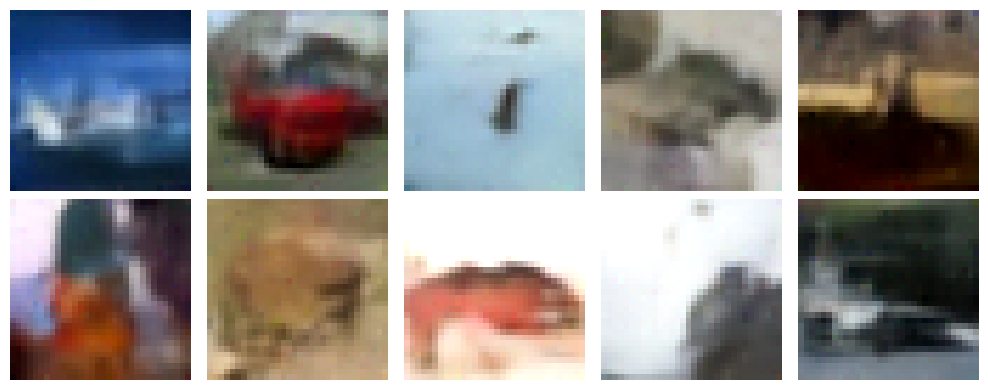

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0149 - i_loss: 0.0442 - val_n_loss: 0.0140 - val_i_loss: 0.0271 - val_kid: 0.2644
Epoch 10/50
1875/1875 [==============================] - ETA: 0s - n_loss: 0.0149 - i_loss: 0.0439

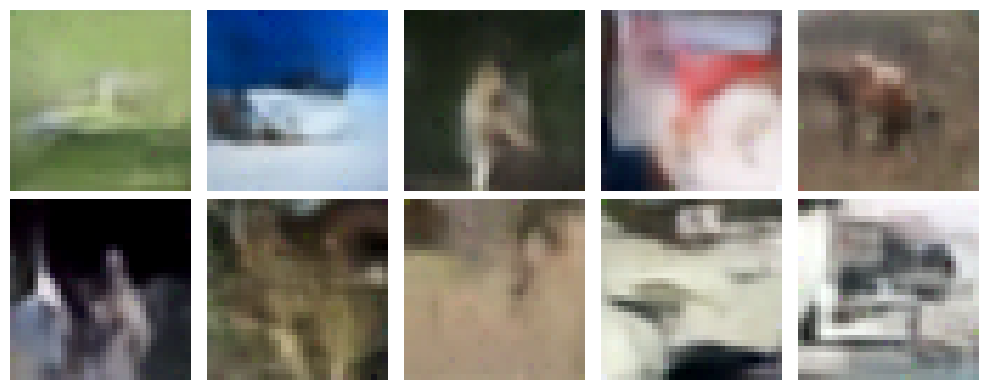

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0149 - i_loss: 0.0439 - val_n_loss: 0.0141 - val_i_loss: 0.0263 - val_kid: 0.2729
Epoch 11/50
1875/1875 [==============================] - ETA: 0s - n_loss: 0.0149 - i_loss: 0.0427

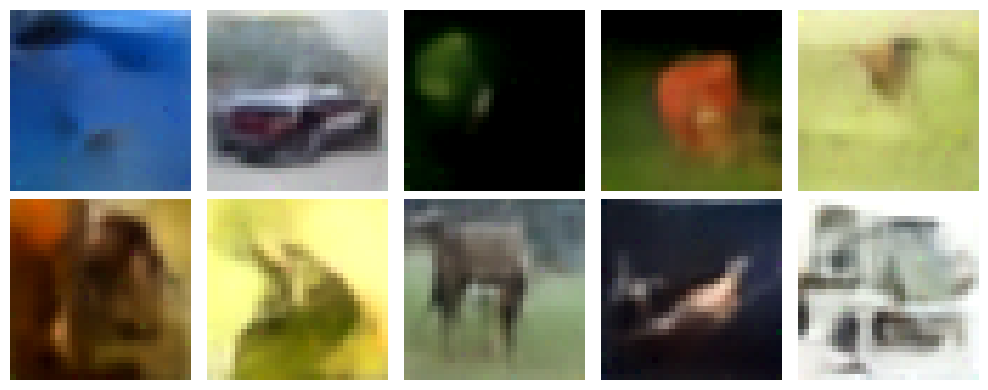

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0149 - i_loss: 0.0427 - val_n_loss: 0.0141 - val_i_loss: 0.0262 - val_kid: 0.2753
Epoch 12/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0148 - i_loss: 0.0428

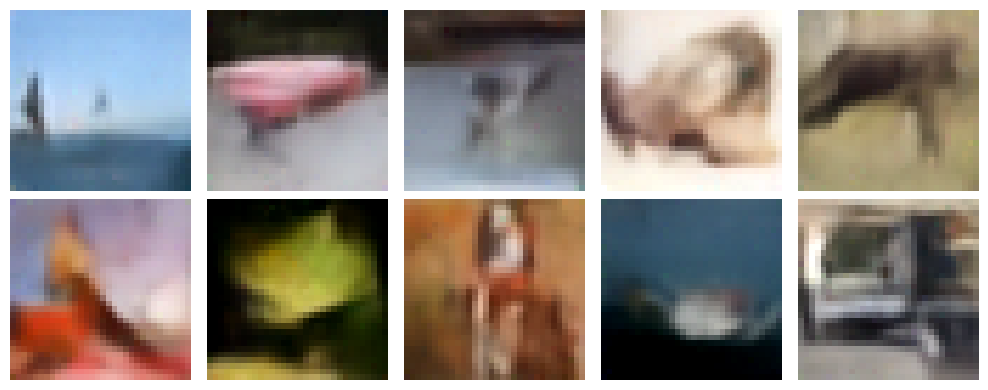

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0148 - i_loss: 0.0428 - val_n_loss: 0.0139 - val_i_loss: 0.0261 - val_kid: 0.2742
Epoch 13/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0148 - i_loss: 0.0434

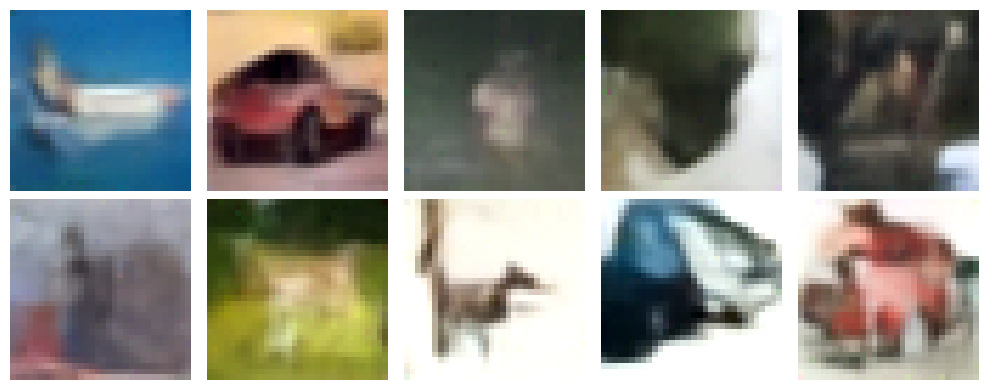

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0148 - i_loss: 0.0434 - val_n_loss: 0.0141 - val_i_loss: 0.0261 - val_kid: 0.2805
Epoch 14/50
1874/1875 [============================>.] - ETA: 0s - n_loss: 0.0147 - i_loss: 0.0413

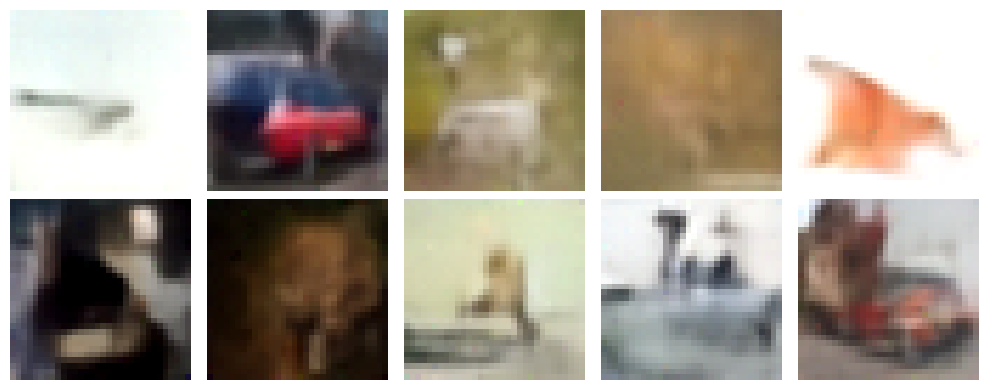

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0147 - i_loss: 0.0413 - val_n_loss: 0.0140 - val_i_loss: 0.0261 - val_kid: 0.2731
Epoch 15/50
1875/1875 [==============================] - ETA: 0s - n_loss: 0.0148 - i_loss: 0.0426

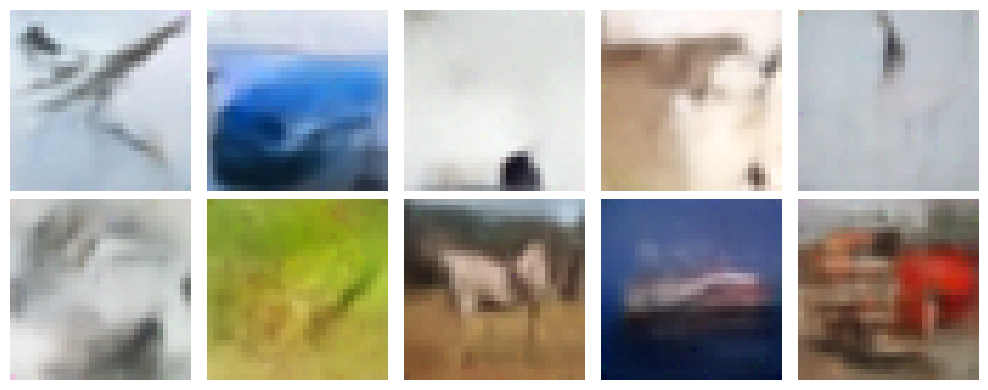

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0148 - i_loss: 0.0426 - val_n_loss: 0.0139 - val_i_loss: 0.0261 - val_kid: 0.2711
Epoch 16/50
1875/1875 [==============================] - ETA: 0s - n_loss: 0.0147 - i_loss: 0.0412

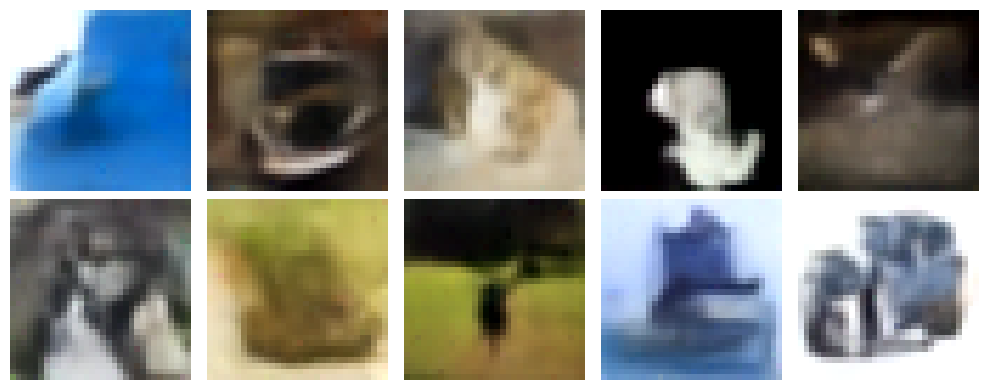

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0147 - i_loss: 0.0412 - val_n_loss: 0.0139 - val_i_loss: 0.0261 - val_kid: 0.2716
Epoch 17/50
1875/1875 [==============================] - ETA: 0s - n_loss: 0.0146 - i_loss: 0.0416

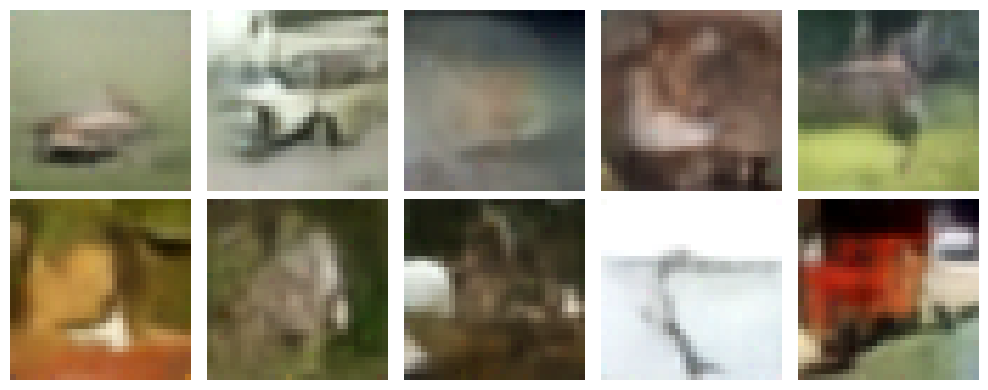

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0146 - i_loss: 0.0416 - val_n_loss: 0.0141 - val_i_loss: 0.0255 - val_kid: 0.2683
Epoch 18/50
1875/1875 [==============================] - ETA: 0s - n_loss: 0.0146 - i_loss: 0.0410

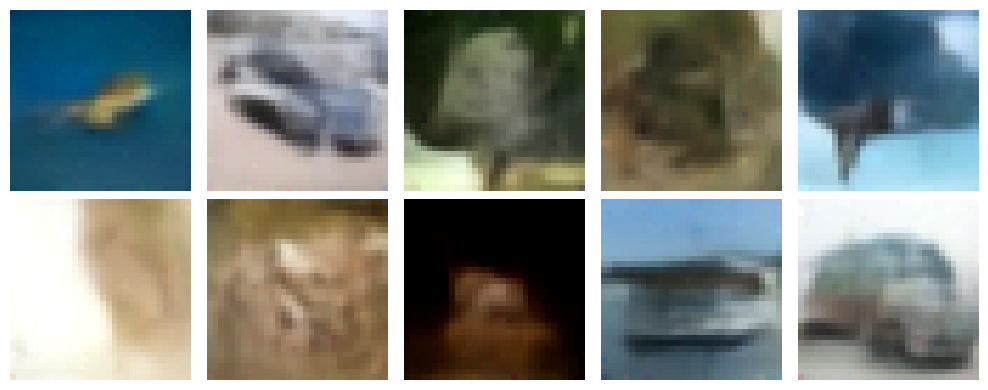

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0146 - i_loss: 0.0410 - val_n_loss: 0.0139 - val_i_loss: 0.0259 - val_kid: 0.2703
Epoch 19/50
1874/1875 [============================>.] - ETA: 0s - n_loss: 0.0147 - i_loss: 0.0408

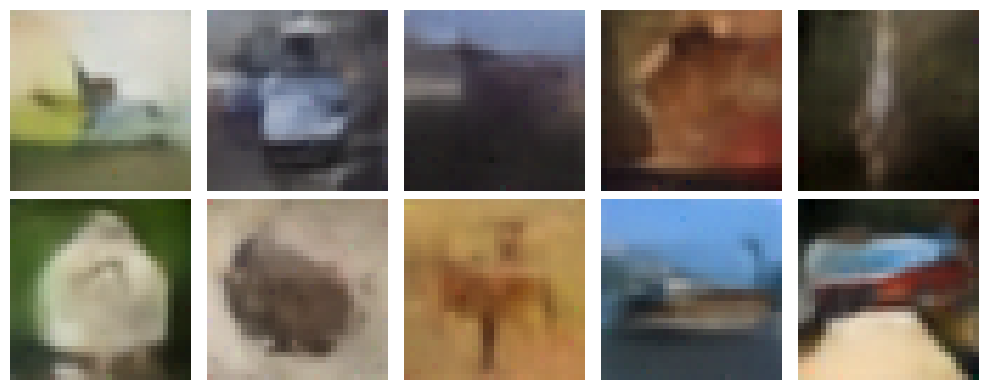

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0147 - i_loss: 0.0408 - val_n_loss: 0.0139 - val_i_loss: 0.0257 - val_kid: 0.2686
Epoch 20/50
1874/1875 [============================>.] - ETA: 0s - n_loss: 0.0147 - i_loss: 0.0399

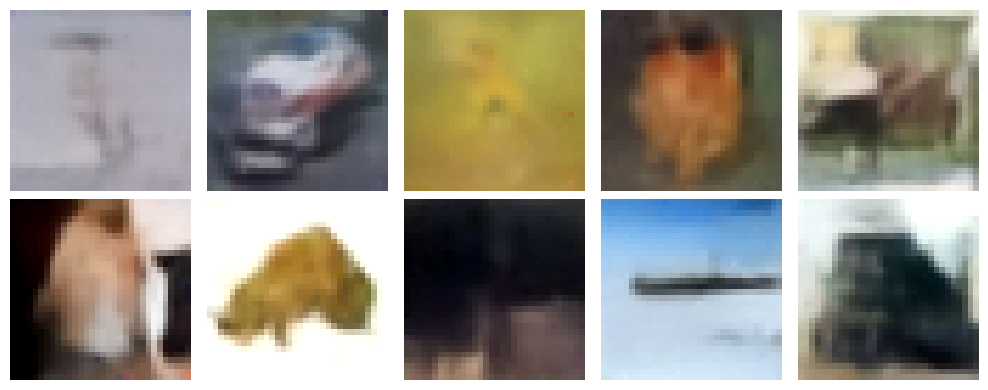

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0147 - i_loss: 0.0400 - val_n_loss: 0.0140 - val_i_loss: 0.0260 - val_kid: 0.2773
Epoch 21/50
1874/1875 [============================>.] - ETA: 0s - n_loss: 0.0146 - i_loss: 0.0411

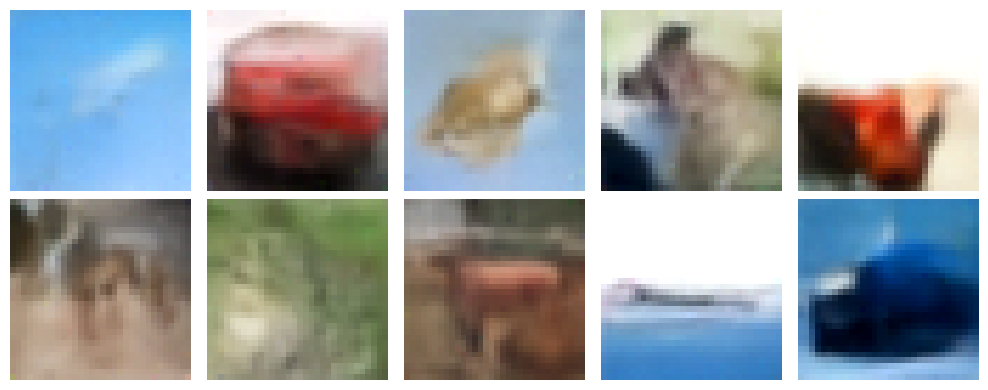

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0146 - i_loss: 0.0411 - val_n_loss: 0.0140 - val_i_loss: 0.0259 - val_kid: 0.2707
Epoch 22/50
1874/1875 [============================>.] - ETA: 0s - n_loss: 0.0147 - i_loss: 0.0399

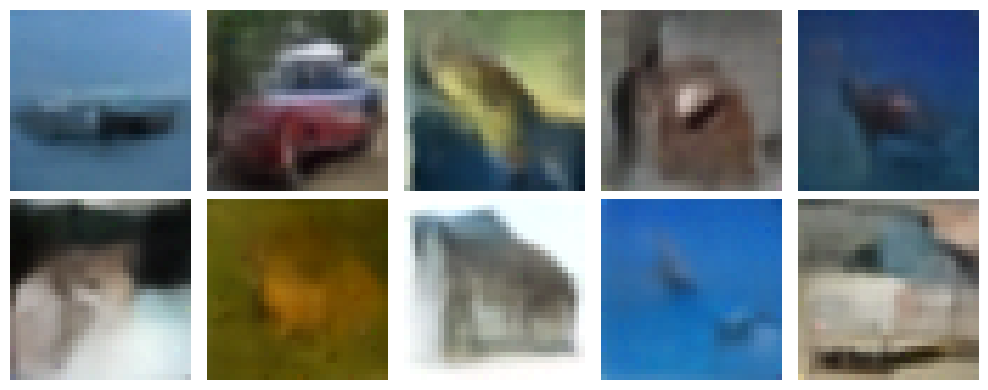

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0147 - i_loss: 0.0399 - val_n_loss: 0.0139 - val_i_loss: 0.0258 - val_kid: 0.2734
Epoch 23/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0147 - i_loss: 0.0396

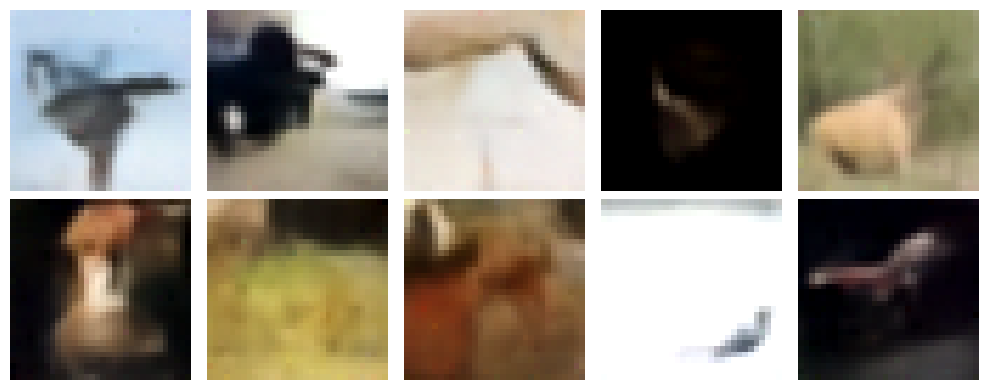

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0147 - i_loss: 0.0396 - val_n_loss: 0.0139 - val_i_loss: 0.0256 - val_kid: 0.2713
Epoch 24/50
1875/1875 [==============================] - ETA: 0s - n_loss: 0.0146 - i_loss: 0.0410

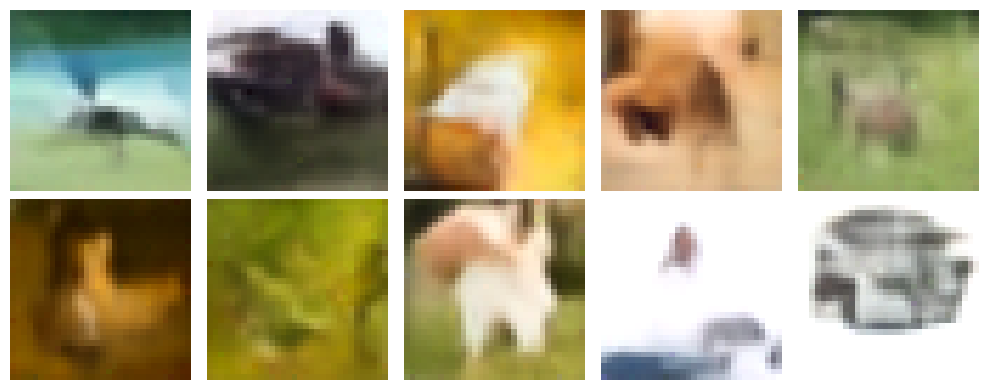

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0146 - i_loss: 0.0410 - val_n_loss: 0.0139 - val_i_loss: 0.0261 - val_kid: 0.2637
Epoch 25/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0146 - i_loss: 0.0399

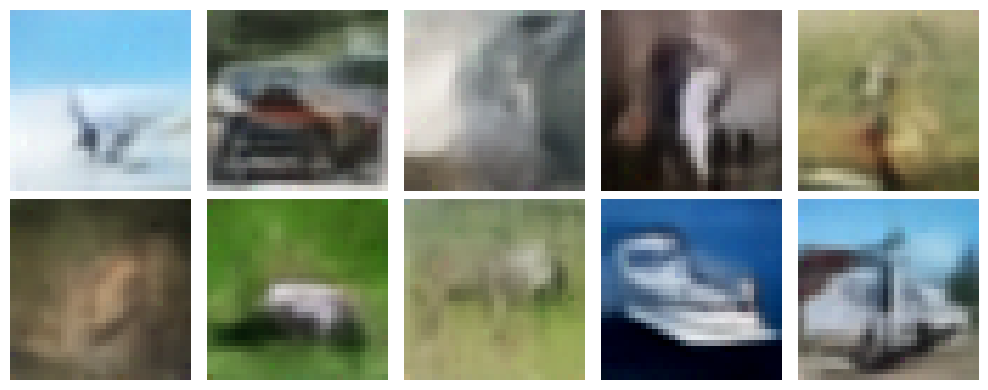

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0146 - i_loss: 0.0399 - val_n_loss: 0.0139 - val_i_loss: 0.0255 - val_kid: 0.2654
Epoch 26/50
1875/1875 [==============================] - ETA: 0s - n_loss: 0.0146 - i_loss: 0.0396

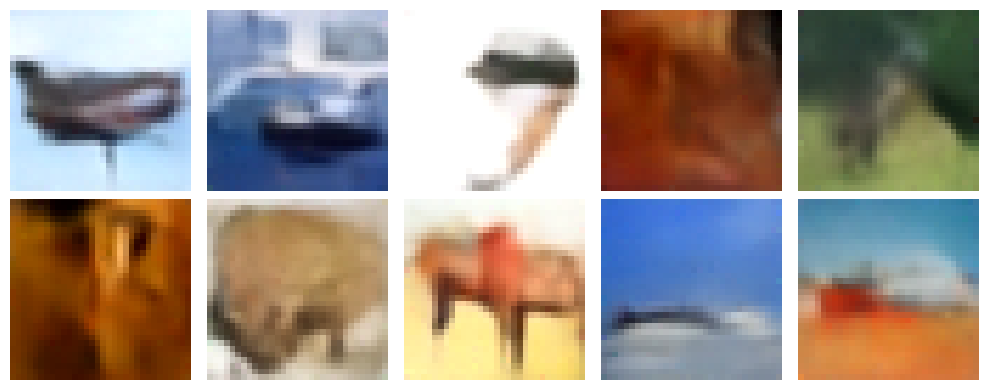

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0146 - i_loss: 0.0396 - val_n_loss: 0.0138 - val_i_loss: 0.0259 - val_kid: 0.2670
Epoch 27/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0146 - i_loss: 0.0398

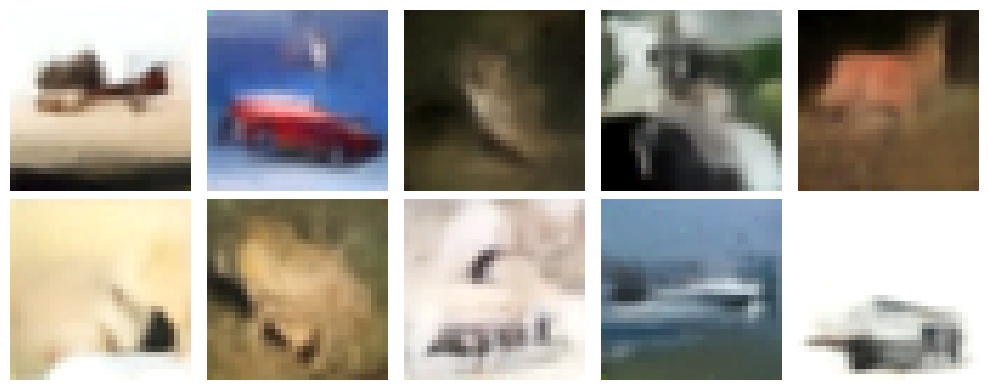

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0146 - i_loss: 0.0398 - val_n_loss: 0.0140 - val_i_loss: 0.0256 - val_kid: 0.2670
Epoch 28/50
1874/1875 [============================>.] - ETA: 0s - n_loss: 0.0146 - i_loss: 0.0396

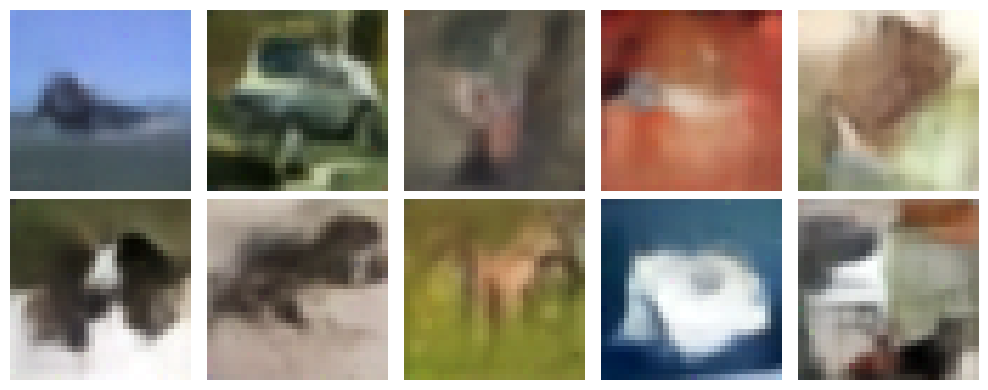

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0146 - i_loss: 0.0396 - val_n_loss: 0.0139 - val_i_loss: 0.0251 - val_kid: 0.2698
Epoch 29/50
1875/1875 [==============================] - ETA: 0s - n_loss: 0.0146 - i_loss: 0.0405

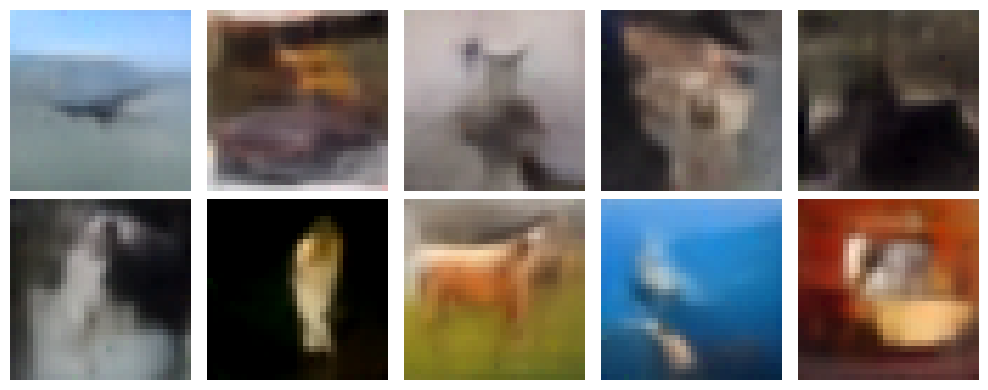

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0146 - i_loss: 0.0405 - val_n_loss: 0.0139 - val_i_loss: 0.0255 - val_kid: 0.2657
Epoch 30/50
1874/1875 [============================>.] - ETA: 0s - n_loss: 0.0146 - i_loss: 0.0398

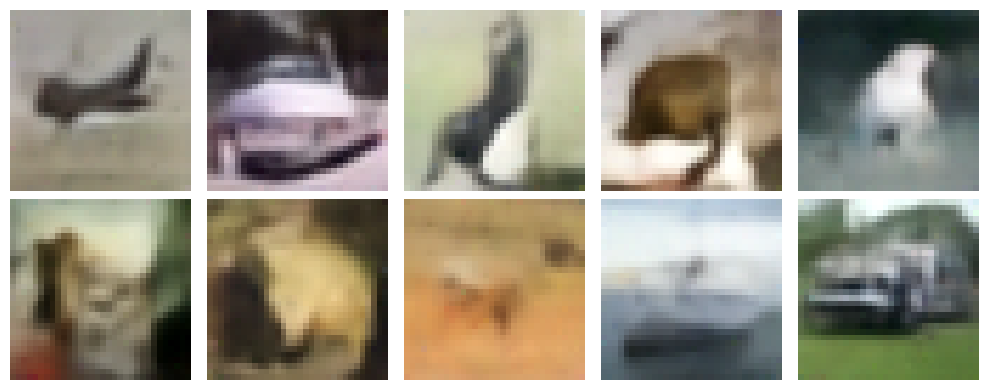

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0146 - i_loss: 0.0398 - val_n_loss: 0.0138 - val_i_loss: 0.0256 - val_kid: 0.2683
Epoch 31/50
1875/1875 [==============================] - ETA: 0s - n_loss: 0.0145 - i_loss: 0.0403

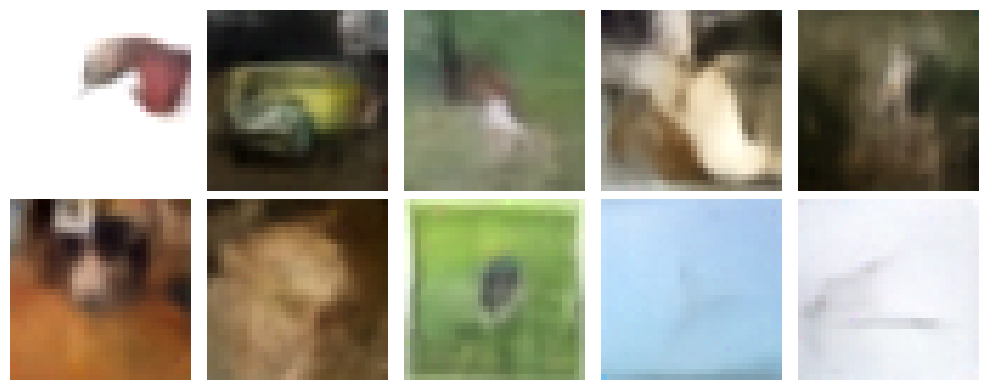

1875/1875 [==============================] - 72s 39ms/step - n_loss: 0.0145 - i_loss: 0.0403 - val_n_loss: 0.0139 - val_i_loss: 0.0257 - val_kid: 0.2621
Epoch 32/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0145 - i_loss: 0.0398

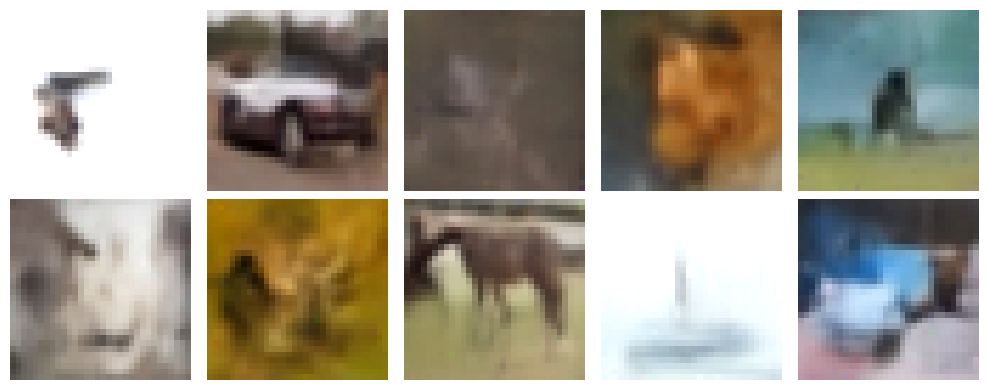

1875/1875 [==============================] - 72s 38ms/step - n_loss: 0.0145 - i_loss: 0.0398 - val_n_loss: 0.0138 - val_i_loss: 0.0256 - val_kid: 0.2648
Epoch 33/50
1875/1875 [==============================] - ETA: 0s - n_loss: 0.0146 - i_loss: 0.0396

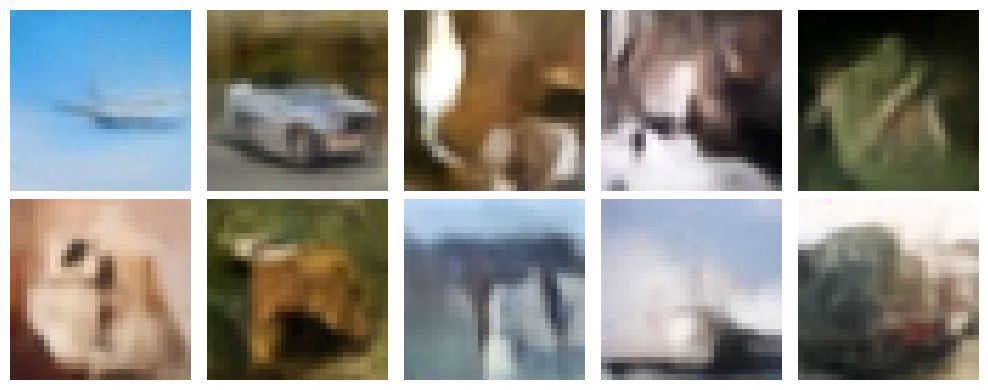

1875/1875 [==============================] - 72s 39ms/step - n_loss: 0.0146 - i_loss: 0.0396 - val_n_loss: 0.0138 - val_i_loss: 0.0256 - val_kid: 0.2616
Epoch 34/50
1874/1875 [============================>.] - ETA: 0s - n_loss: 0.0145 - i_loss: 0.0394

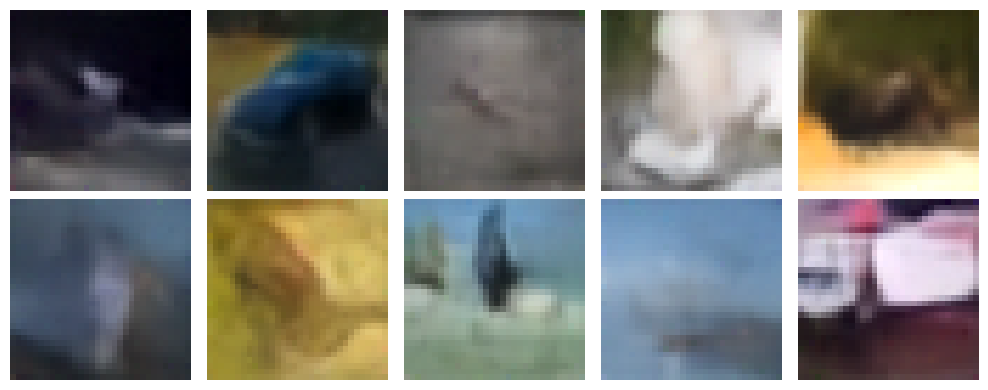

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0145 - i_loss: 0.0394 - val_n_loss: 0.0140 - val_i_loss: 0.0254 - val_kid: 0.2678
Epoch 35/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0146 - i_loss: 0.0396

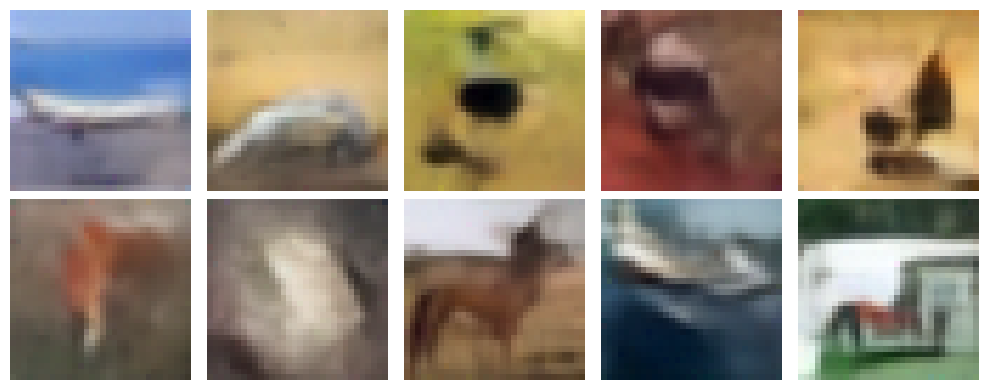

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0146 - i_loss: 0.0396 - val_n_loss: 0.0138 - val_i_loss: 0.0253 - val_kid: 0.2639
Epoch 36/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0146 - i_loss: 0.0392

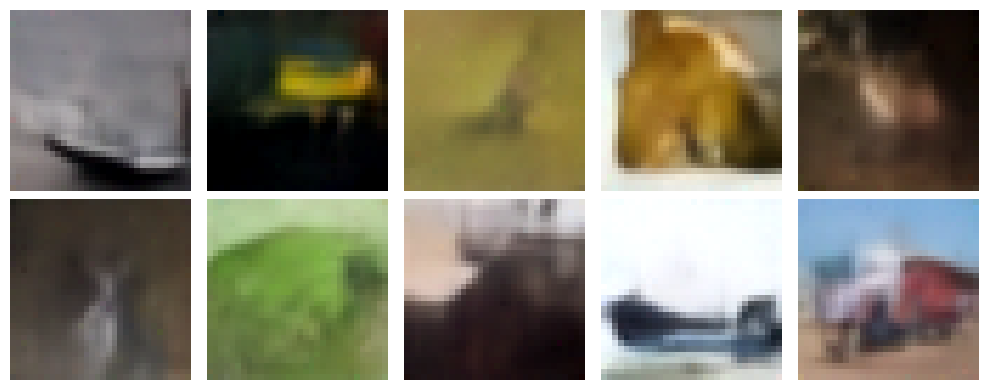

1875/1875 [==============================] - 72s 38ms/step - n_loss: 0.0146 - i_loss: 0.0392 - val_n_loss: 0.0139 - val_i_loss: 0.0251 - val_kid: 0.2579
Epoch 37/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0146 - i_loss: 0.0397

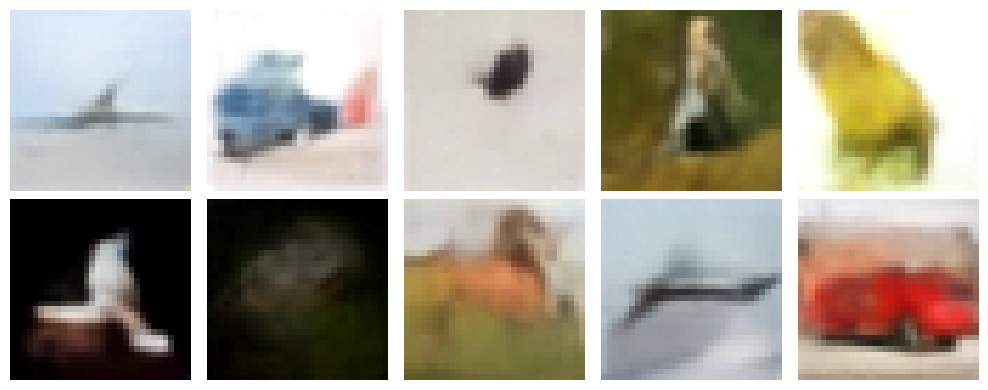

1875/1875 [==============================] - 72s 39ms/step - n_loss: 0.0146 - i_loss: 0.0397 - val_n_loss: 0.0139 - val_i_loss: 0.0257 - val_kid: 0.2562
Epoch 38/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0145 - i_loss: 0.0392

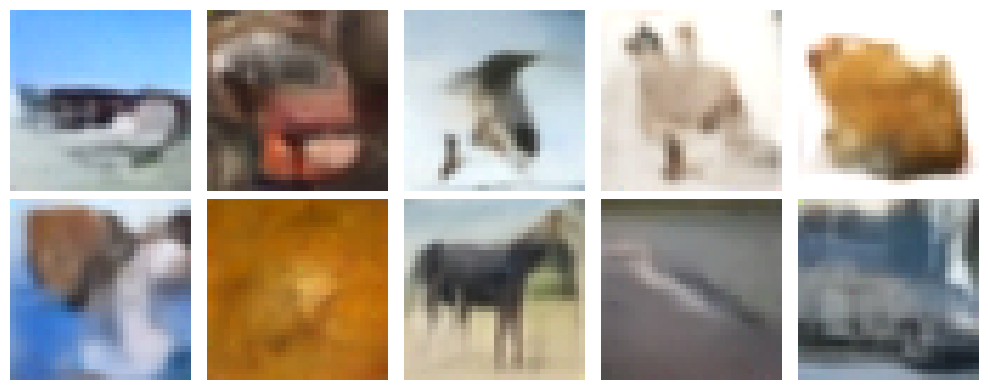

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0145 - i_loss: 0.0392 - val_n_loss: 0.0138 - val_i_loss: 0.0256 - val_kid: 0.2620
Epoch 39/50
1875/1875 [==============================] - ETA: 0s - n_loss: 0.0145 - i_loss: 0.0396

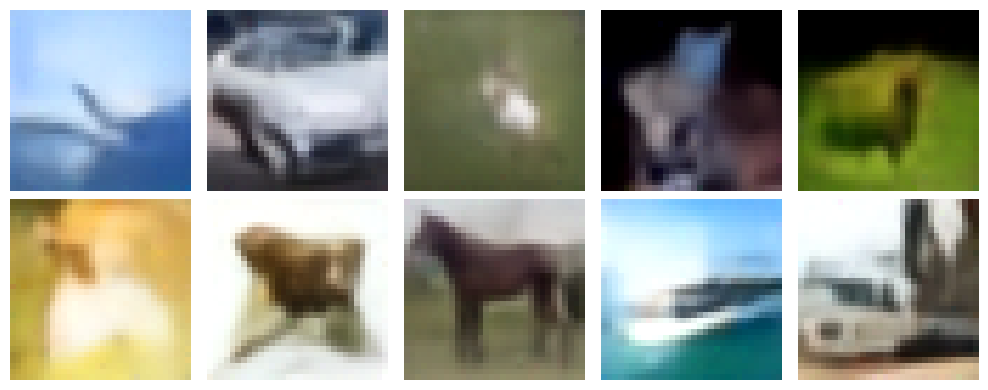

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0145 - i_loss: 0.0396 - val_n_loss: 0.0137 - val_i_loss: 0.0253 - val_kid: 0.2616
Epoch 40/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0145 - i_loss: 0.0394

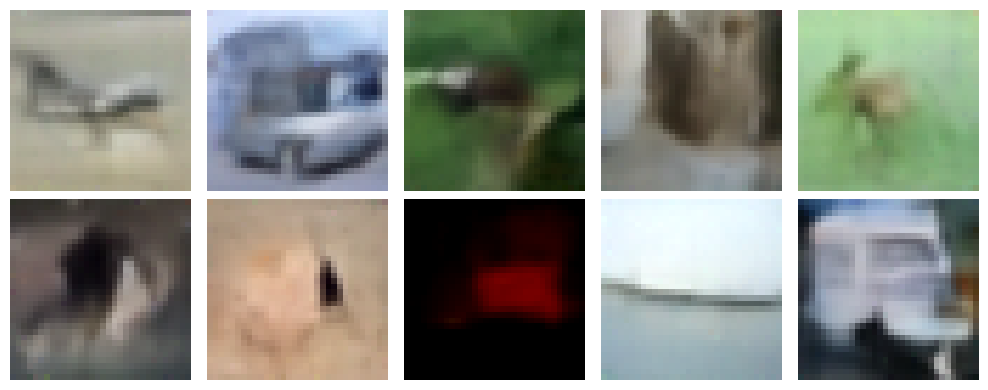

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0145 - i_loss: 0.0394 - val_n_loss: 0.0138 - val_i_loss: 0.0256 - val_kid: 0.2633
Epoch 41/50
1874/1875 [============================>.] - ETA: 0s - n_loss: 0.0145 - i_loss: 0.0400

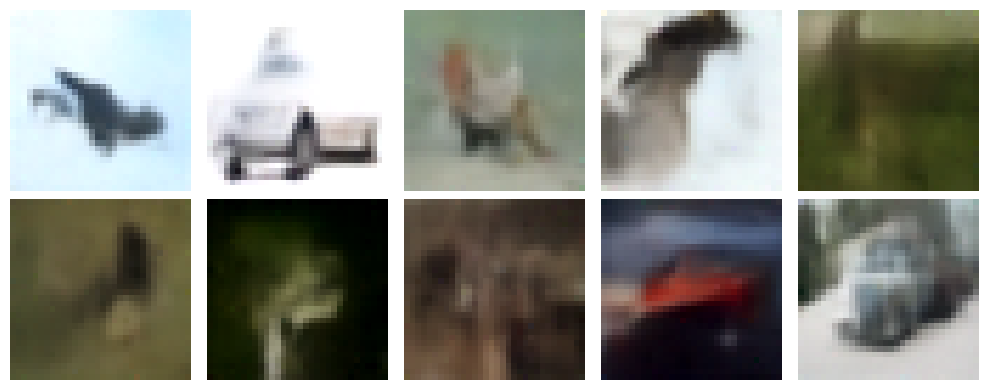

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0145 - i_loss: 0.0400 - val_n_loss: 0.0139 - val_i_loss: 0.0254 - val_kid: 0.2632
Epoch 42/50
1875/1875 [==============================] - ETA: 0s - n_loss: 0.0145 - i_loss: 0.0394

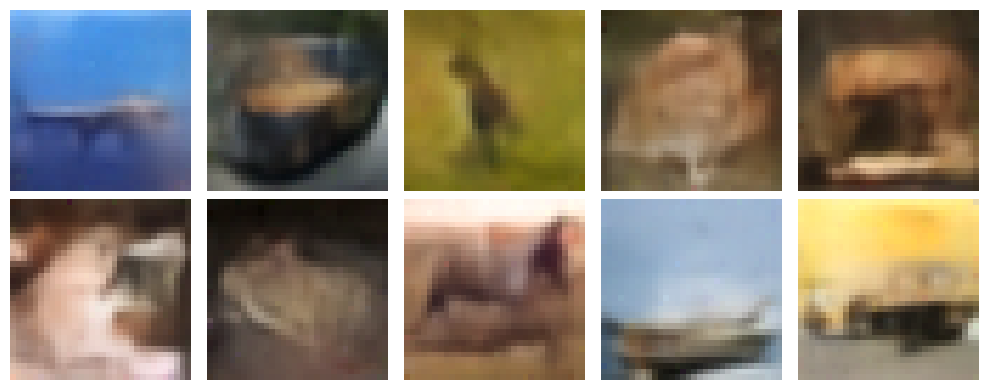

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0145 - i_loss: 0.0394 - val_n_loss: 0.0138 - val_i_loss: 0.0254 - val_kid: 0.2569
Epoch 43/50
1874/1875 [============================>.] - ETA: 0s - n_loss: 0.0145 - i_loss: 0.0390

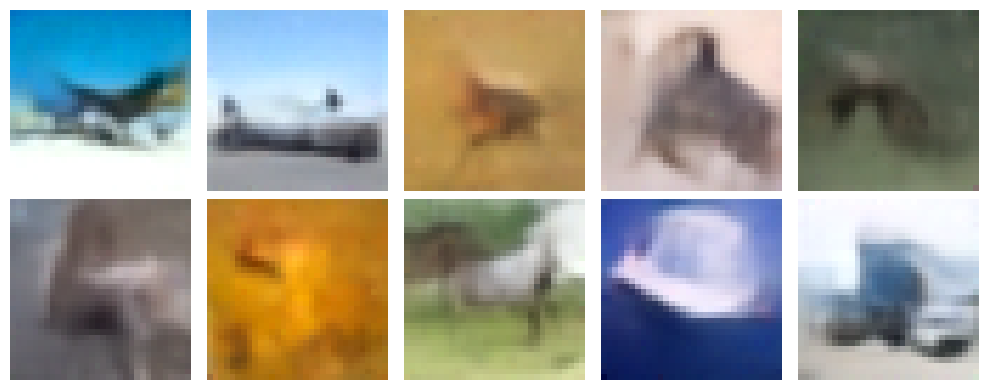

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0145 - i_loss: 0.0390 - val_n_loss: 0.0140 - val_i_loss: 0.0255 - val_kid: 0.2599
Epoch 44/50
1875/1875 [==============================] - ETA: 0s - n_loss: 0.0146 - i_loss: 0.0397

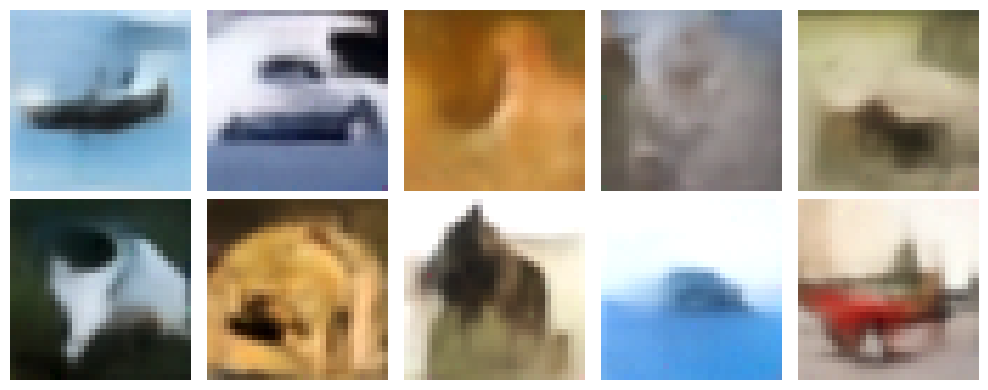

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0146 - i_loss: 0.0397 - val_n_loss: 0.0139 - val_i_loss: 0.0259 - val_kid: 0.2608
Epoch 45/50
1875/1875 [==============================] - ETA: 0s - n_loss: 0.0145 - i_loss: 0.0393

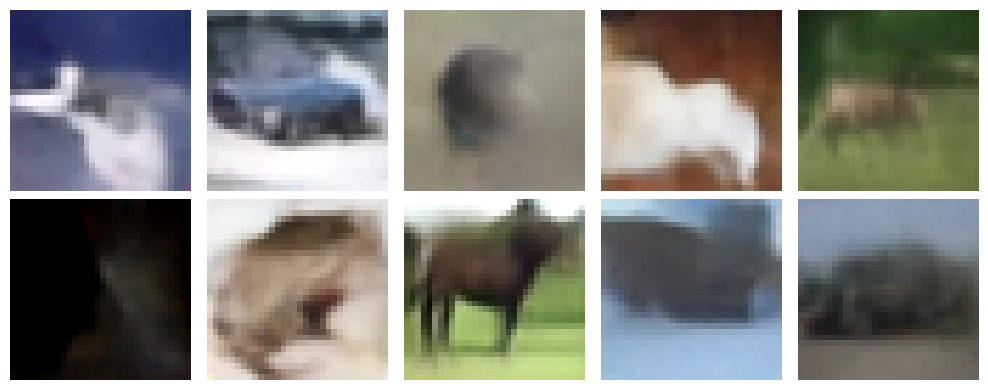

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0145 - i_loss: 0.0393 - val_n_loss: 0.0138 - val_i_loss: 0.0253 - val_kid: 0.2596
Epoch 46/50
1874/1875 [============================>.] - ETA: 0s - n_loss: 0.0145 - i_loss: 0.0391

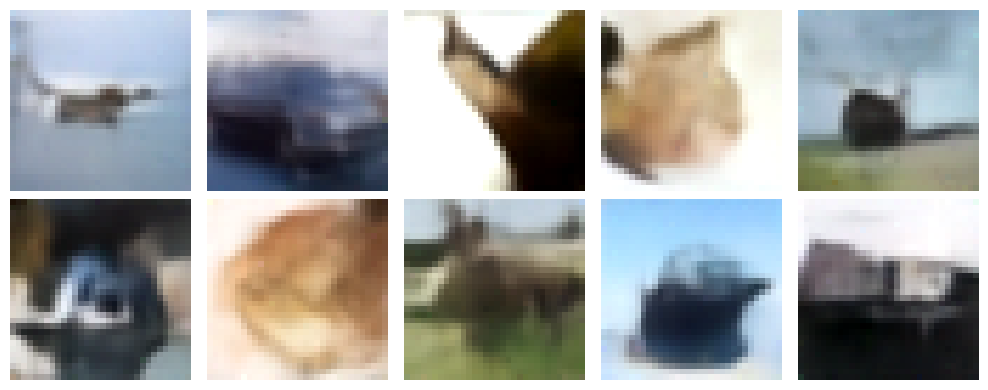

1875/1875 [==============================] - 72s 38ms/step - n_loss: 0.0145 - i_loss: 0.0391 - val_n_loss: 0.0139 - val_i_loss: 0.0253 - val_kid: 0.2543
Epoch 47/50
1874/1875 [============================>.] - ETA: 0s - n_loss: 0.0144 - i_loss: 0.0394

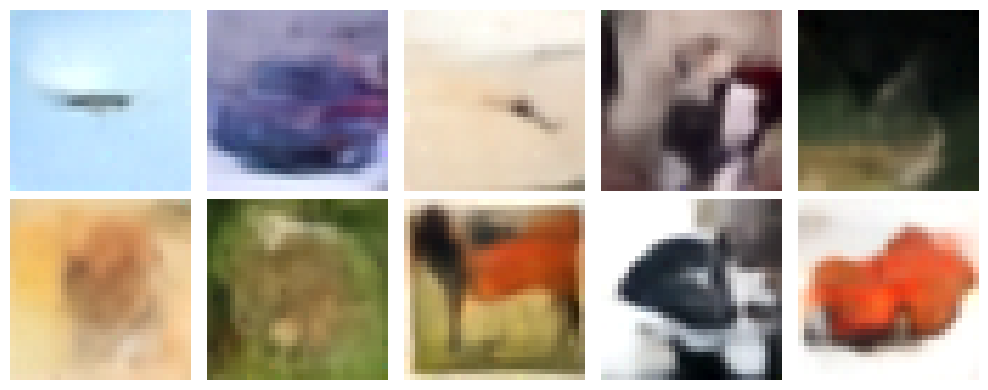

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0144 - i_loss: 0.0394 - val_n_loss: 0.0138 - val_i_loss: 0.0253 - val_kid: 0.2566
Epoch 48/50
1874/1875 [============================>.] - ETA: 0s - n_loss: 0.0145 - i_loss: 0.0397

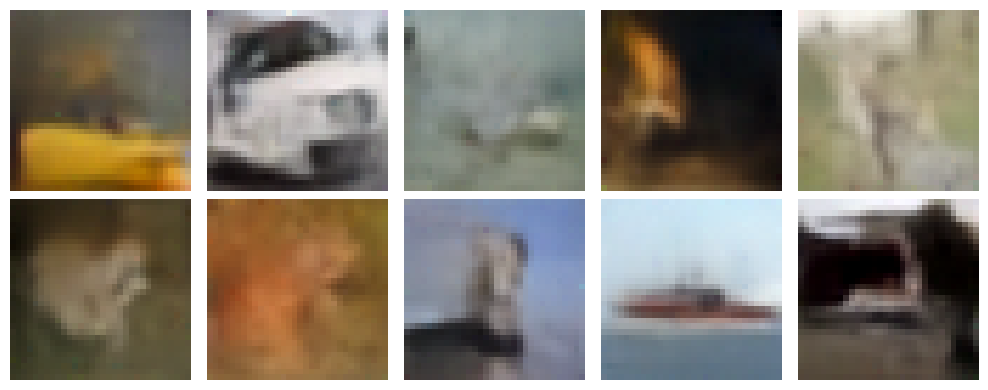

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0145 - i_loss: 0.0397 - val_n_loss: 0.0138 - val_i_loss: 0.0256 - val_kid: 0.2561
Epoch 49/50
1874/1875 [============================>.] - ETA: 0s - n_loss: 0.0145 - i_loss: 0.0390

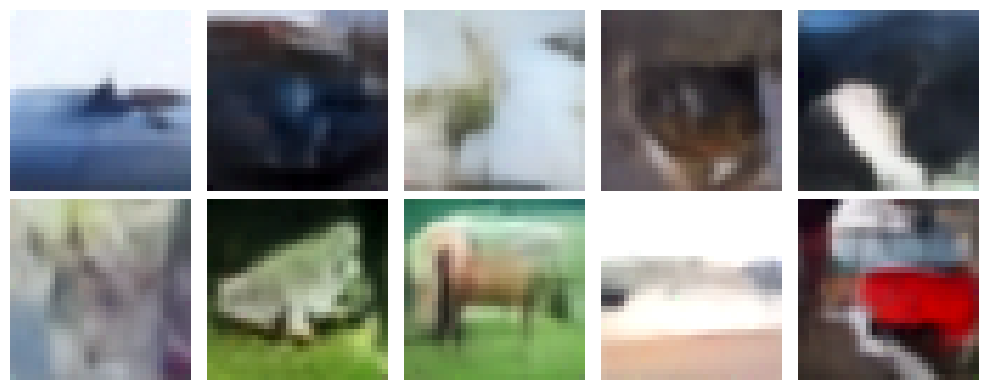

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0145 - i_loss: 0.0390 - val_n_loss: 0.0138 - val_i_loss: 0.0254 - val_kid: 0.2600
Epoch 50/50
1873/1875 [============================>.] - ETA: 0s - n_loss: 0.0145 - i_loss: 0.0404

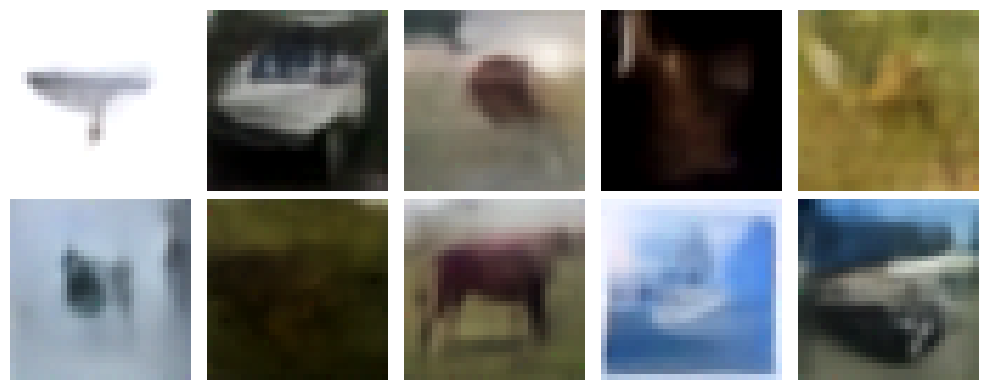

1875/1875 [==============================] - 71s 38ms/step - n_loss: 0.0145 - i_loss: 0.0404 - val_n_loss: 0.0138 - val_i_loss: 0.0253 - val_kid: 0.2582


In [19]:
# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end = model.plot_images),
        checkpoint_callback,
    ],
)

## 인퍼런스

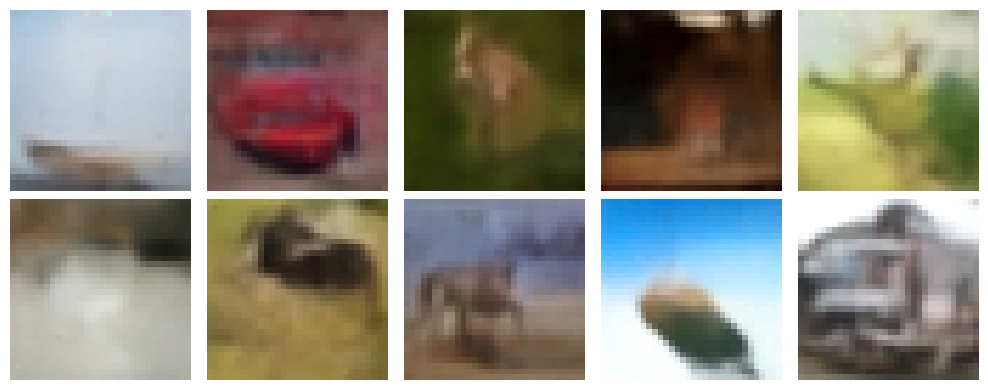

In [20]:
# load the best model and generate images
model.load_weights(checkpoint_path)
model.plot_images()